In [31]:
import os
import warnings
import argparse
import datetime
import pathlib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

from test_simple_cnn import test
from utils.evaluate_uncertainty import evaluate_uncertainty
from core.config import create_config, save_config
from core.dataset_grayscale import COCODataset
from core.model import Model
from core.metrics import AccuracyLogger
from torchvision import models
import timm
import matplotlib.pyplot as plt

In [32]:
import pickle

In [33]:
with open('dummy_args.p','rb') as F:
    args = pickle.load(F)
    
with open('dummy_cfg.p','rb') as F:
    cfg = pickle.load(F)

In [34]:
args.annotations

'../iLab/annotation_files/train_iLab_viewpoints_v3.json'

In [112]:
args.annotations = '../iLab/annotation_files/train_iLab_viewpoints_v3_extreme.json'

In [113]:
cfg.annotations = '../iLab/annotation_files/train_iLab_viewpoints_v3_extreme.json'

In [62]:
dataset = COCODataset(cfg.annotations, cfg.imagedir, image_size =(224,224), normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, num_workers=4, shuffle=False, pin_memory=True, drop_last=True)

NUM_CLASSES = dataset.NUM_CLASSES
cfg.num_classes = NUM_CLASSES
# save_config(cfg, args.outdir)
print(cfg)



-------------------------------
Annotation Counts
-------------------------------
f1car                      1548
pickup                     1782
plane                      1334
van                        1590
car                        4824
monster                    1388
equip                      1564
tank                       1938
semi                       1614
heli                       1908
ufo                        1214
mil                        3480
bus                        1950
boat                       1840
train                      1558
Total                     29532
-------------------------------

annotations: ../iLab/annotation_files/train_iLab_light_v3_extreme.json
batch_size: 40
checkpoint: null
git: e22ff54d4e15e859ff3672c5fc808cec0abfc80d
imagedir: ../
imbalance_reweighting: false
learning_rate: 1.0e-05
num_classes: 15
num_decoder_heads: 8
num_decoder_layers: 6
test_annotations: ../iLab/annotation_files/test_iLab_viewpoints_v3.json
test_imagedir: ../
uncertai

In [63]:
for data in dataloader:
    break

In [64]:
len(data)

4

In [65]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [66]:
unorm = UnNormalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

In [67]:
%matplotlib inline

0


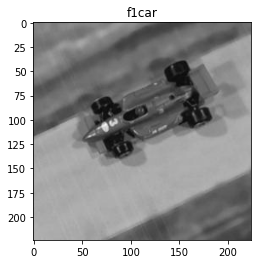

In [68]:
import random
ID = random.choice(range(cfg.batch_size))
print(ID)
plt.imshow(unorm(data[0][ID]).permute(1,2,0))
plt.title(dataset.idx2label[data[3][ID].item()])
# plt.title(data[3][ID].item())
plt.show()

In [69]:
data[0].shape

torch.Size([40, 3, 224, 224])

# Investigate file names

In [114]:
import json
from PIL import Image

In [147]:
train_annotations = '../iLab/annotation_files/train_iLab_viewpoints_v3_extreme.json'
test_annotatios = '../iLab/annotation_files/test_iLab_viewpoints_v3_extreme.json'

In [148]:
def get_all_images(ann_file):
    with open(ann_file,'r') as F:
        contents = json.load(F)
    im_dicts = contents['images']
    all_images = []
    for imd in im_dicts:
        all_images.append(imd['file_name'])
    return sorted(all_images)

In [149]:
train_images = get_all_images(train_annotations)
test_images = get_all_images(test_annotatios)

In [150]:
len(train_images)

29657

In [151]:
len(test_images)

14766

In [136]:
train_images[0]

'iLab/home2/toy/iLab2M/train_img/boat-i0003-b0000-c00-r01-l0-f2.jpg'

In [137]:
test_images[0]

'iLab/home2/toy/iLab2M/train_img/boat-i0003-b0000-c00-r03-l0-f2.jpg'

In [138]:
from PIL import ImageOps

In [170]:
# ID = random.choice(list(range(len(test_images))))
ID = 1200

In [184]:
train_images[ID]

'iLab/home2/toy/iLab2M/train_img/boat-i2825-b0074-c02-r07-l0-f2.jpg'

In [176]:
train_images[ID-1]

'iLab/home2/toy/iLab2M/train_img/boat-i2825-b0074-c02-r01-l0-f2.jpg'

In [182]:
# tra[int(ID/2)]

In [186]:
for i in test_images:
    if 'iLab/home2/toy/iLab2M/train_img/boat-i2825-b0074' in i:
        print(i)

iLab/home2/toy/iLab2M/train_img/boat-i2825-b0074-c00-r03-l0-f2.jpg
iLab/home2/toy/iLab2M/train_img/boat-i2825-b0074-c04-r03-l0-f2.jpg
iLab/home2/toy/iLab2M/train_img/boat-i2825-b0074-c07-r03-l0-f2.jpg


# Build figure for paper

In [1]:
ilab_folder = '../iLab/home2/toy/iLab2M/'

In [27]:
import os
from PIL import Image
import random

In [122]:
main_folder = os.path.join(ilab_folder, 'val_img')

In [123]:
mat_fol = os.path.join(ilab_folder, 'masked_val_img_1')

In [124]:
light_fol = os.path.join(ilab_folder, 'val_img_light_2')

In [125]:
files = os.listdir(new_fol)

In [126]:
len(files)

24146

In [127]:
# 5976
# 22513

In [139]:
rand_num = 459

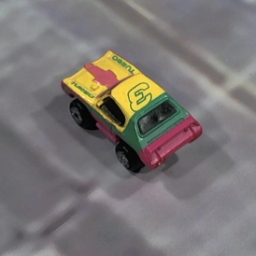

In [140]:
# rand_num = random.choice(range(len(files)))
Image.open(os.path.join(main_folder,files[rand_num]))

In [141]:
new_viewpoint_img = 'car-i0140-b0111-c02-r04-l0-f2.jpg'

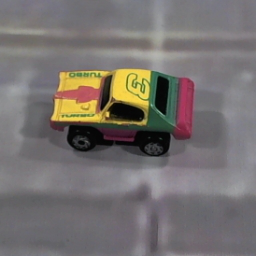

In [145]:
Image.open(os.path.join(main_folder,new_viewpoint_img))

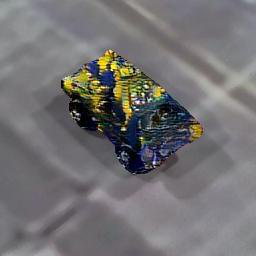

In [142]:
Image.open(os.path.join(mat_fol,files[rand_num]))

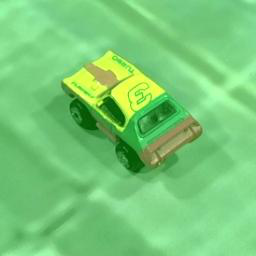

In [143]:
Image.open(os.path.join(light_fol,files[rand_num]))

In [96]:
os.listdir(ilab_folder)

['masked_light_1_train_more_combinations_img_1',
 'masked_light_4_train_img_1',
 'val_img_5_old',
 'train_img',
 'masked_light_4_train_img_4',
 'masked_light_1_val_img_5',
 'masked_light_5_train_img_5',
 'val_img_2_old',
 'masked_light_3_val_img_4',
 'train_img_2_old',
 'val_img_masks',
 'masked_light_1_train_img_1',
 'masked_val_img_3',
 'masked_light_2_val_img_5',
 'masked_light_1_val_more_combinations_img_1',
 '.ipynb_checkpoints',
 'masked_light_2_train_img_4',
 'masked_light_1_train_img_2',
 'train_img_light_3',
 'masked_light_2_val_img_4',
 'train_img_light_5',
 'val_img_light_5',
 'masked_light_3_train_img_2',
 'masked_light_5_val_img_2',
 'masked_light_4_val_more_combinations_img_4',
 'val_img_2',
 'masked_light_5_val_img_3',
 'masked_light_5_val_img_1',
 'masked_light_5_val_img_4',
 'val_img_3_old',
 'masked_light_5_val_more_combinations_img_5',
 'masked_light_1_val_img_3',
 'val_img_light_4',
 'masked_light_4_train_img_5',
 'masked_light_2_val_more_combinations_img_2',
 'mask